## Vegetation Type Classification, Pveg

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import resize

In [9]:
def load_and_normalize_ndvi(file_path):
    """Load NDVI data from a GeoTIFF file and normalize to [0, 1]"""
    with rasterio.open(file_path) as src:
        ndvi = src.read(1)  # Read NDVI band
        
    norm_ndvi = (ndvi - np.min(ndvi)) / (np.max(ndvi) - np.min(ndvi)) # Normalize NDVI to range [0, 1]
    return norm_ndvi

In [11]:
def classify_vegetation(ndvi_norm):
    """
    Classify NDVI values into vegetation types:
      0: No vegetation (NDVI < 0.2)
      1: Agriculture (NDVI between 0.4 and 0.6)
      2: Shrub/Grassland (NDVI between 0.2 and 0.4)
      3: Trees/Forests (NDVI > 0.6)
      
      Vegetation types classified into 3 categories (Alexandridis et al., 2008)

    note: 
      NDVI thresholds for vegetation types vary across sources, 
      so some misclassification may occur. Especially for agriculture 
      which NDVI scores can overlap with trees. The thresholds were also 
      adjusted to ensure continous classification with no unclassifid values.
    """
    veg_type = np.zeros_like(ndvi_norm, dtype=np.int32)
    
    veg_type[ndvi_norm < 0.2] = 0 # No vegetation
    
    veg_type[(ndvi_norm >= 0.2) & (ndvi_norm <= 0.4)] = 2 # Vegetation type 2 (shrubs/grassland)
    
    veg_type[(ndvi_norm >= 0.4) & (ndvi_norm <= 0.6)] = 1 # Vegetation type 1 (agriculture)
    
    veg_type[ndvi_norm > 0.6] = 3 # Vegetation type 3 (trees/forests)
    
    return veg_type

In [25]:
def aggregate_ndvi(ndvi, factor):
    """
    Aggregate NDVI values by averaging over non-overlapping blocks.
    
    ndvi: 2D numpy array of per-pixel NDVI values.
    factor: number of pixels to aggregate along each dimension.
    """
    new_rows = ndvi.shape[0] // factor
    new_cols = ndvi.shape[1] // factor
    aggregated = ndvi[:new_rows*factor, :new_cols*factor].reshape(new_rows, factor, new_cols, factor).mean(axis=(1, 3))
    return aggregated

def renormalize_ndvi(ndvi_array):
    return (ndvi_array - np.min(ndvi_array)) / (np.max(ndvi_array) - np.min(ndvi_array))


### Testing

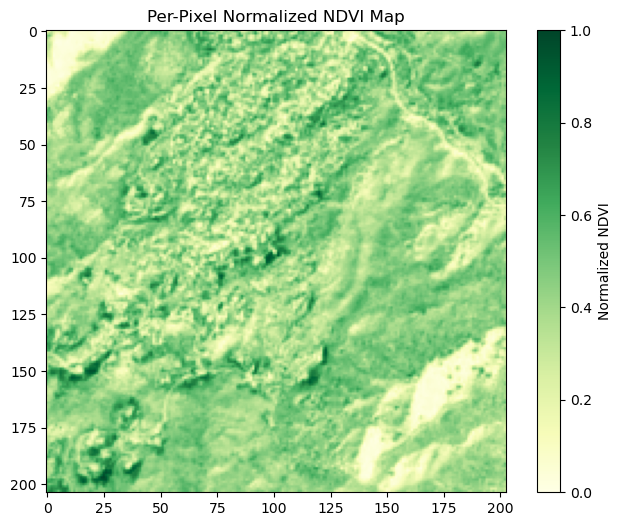

In [18]:
ndvi_file_path = "data/CA_VEG_Sentinel2_NDVI.tif"
ndvi_norm = load_and_normalize_ndvi(ndvi_file_path)
veg_classification = classify_vegetation(ndvi_norm)

plt.figure(figsize=(8, 6))
plt.imshow(ndvi_norm, cmap="YlGn")
plt.colorbar(label="Normalized NDVI")
plt.title("Per-Pixel Normalized NDVI Map")
plt.show()


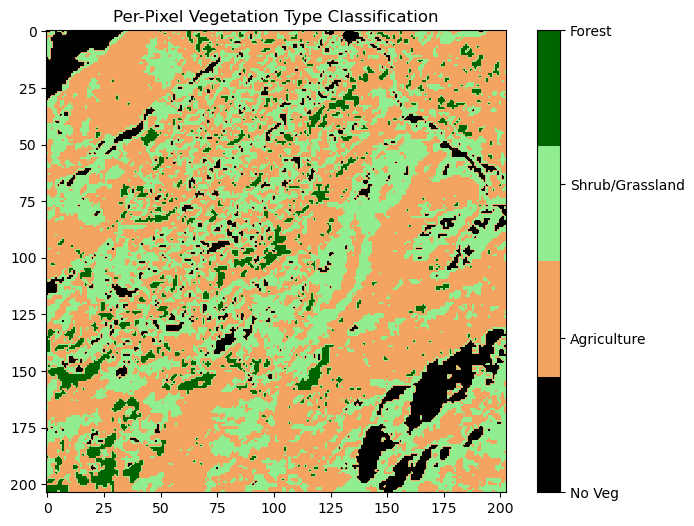

In [21]:
# Land cover classification custom color map
fuel_cmap = ListedColormap(['black', 'sandybrown', 'lightgreen', 'darkgreen'])

plt.figure(figsize=(8, 6))
plt.imshow(veg_classification, cmap=fuel_cmap)
cbar = plt.colorbar(ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['No Veg', 'Agriculture', 'Shrub/Grassland', 'Forest'])
plt.title("Per-Pixel Vegetation Type Classification")
plt.show()

### Aggregated pixels
#### Not sure if necessary. Can also impliment Google Tiles API instead.

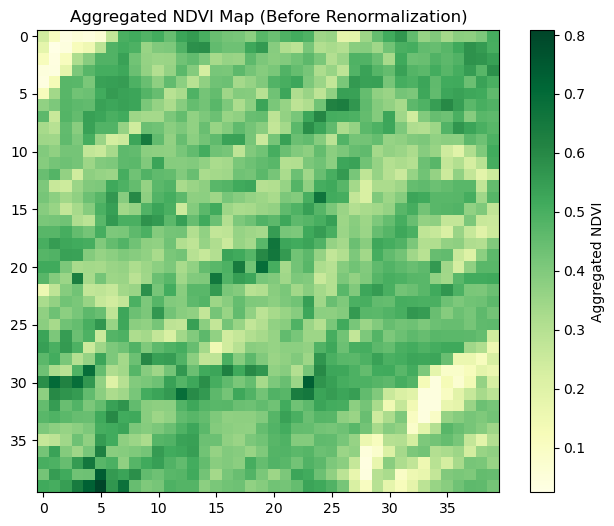

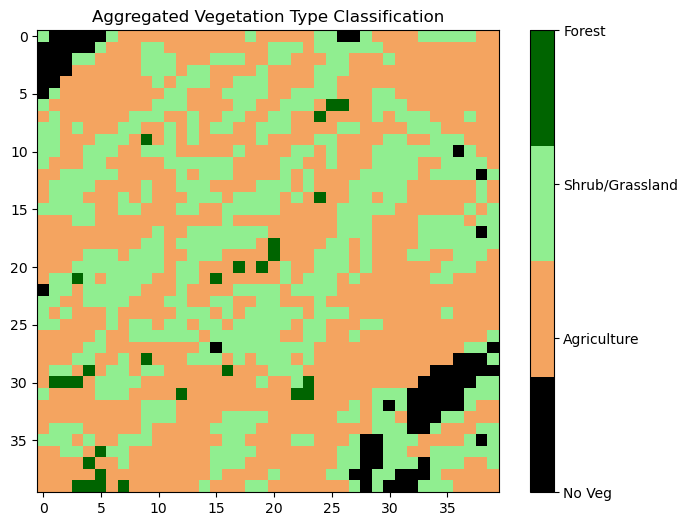

In [29]:
# Aggregate NDVI Values into Averaged Grid Cells
aggregation_factor = 5  #Group 5x5 pixels into one cell
ndvi_aggregated = aggregate_ndvi(ndvi_norm, aggregation_factor)
ndvi_aggregated_renorm = renormalize_ndvi(ndvi_aggregated)

plt.figure(figsize=(8, 6))
plt.imshow(ndvi_aggregated, cmap="YlGn")
plt.colorbar(label="Aggregated NDVI")
plt.title("Aggregated NDVI Map (Before Renormalization)")
plt.show()

veg_classification_agg = classify_vegetation(ndvi_aggregated)

plt.figure(figsize=(8, 6))
plt.imshow(veg_classification_agg, cmap=fuel_cmap)
cbar = plt.colorbar(ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['No Veg', 'Agriculture', 'Shrub/Grassland', 'Forest'])
plt.title("Aggregated Vegetation Type Classification")
plt.show()

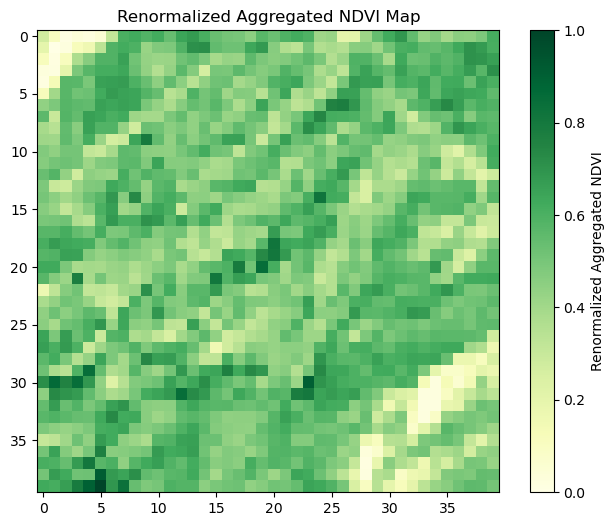

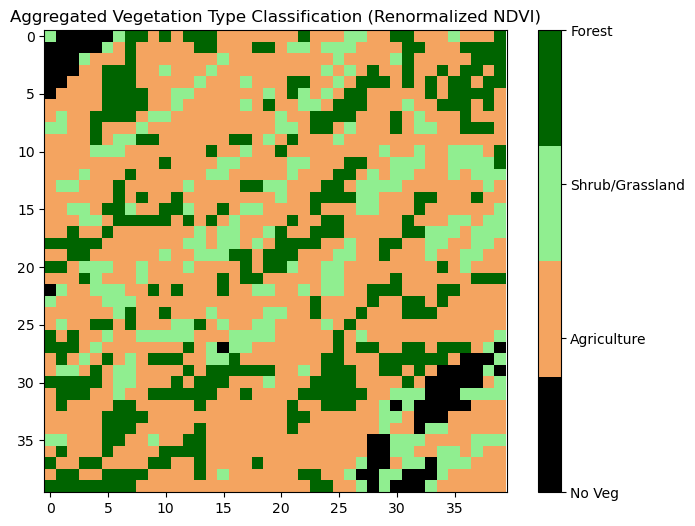

In [31]:
# Renormalize NDVI based on aggregated values
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_aggregated_renorm, cmap="YlGn")
plt.colorbar(label="Renormalized Aggregated NDVI")
plt.title("Renormalized Aggregated NDVI Map")
plt.show()

veg_classification_agg = classify_vegetation(ndvi_aggregated_renorm)
fuel_cmap = ListedColormap(['black', 'sandybrown', 'lightgreen', 'darkgreen'])
plt.figure(figsize=(8, 6))
plt.imshow(veg_classification_agg, cmap=fuel_cmap)
cbar = plt.colorbar(ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['No Veg', 'Agriculture', 'Shrub/Grassland', 'Forest'])
plt.title("Aggregated Vegetation Type Classification (Renormalized NDVI)")
plt.show()

# Not sure if this is necessary or accurate as it skewed data towards higher NDVI values.

### Simulating wildfire spread with different burn rates for vegetation types

#### New Pveg values from literature

In [40]:
# Vegetation Type Burn Modifiers (Pveg) from Alexandridis et al., 2008.
fuel_to_factor = {
    1: -0.3,   # Agriculture
    2: 0.0,    # Thickets (Shrub/Grassland)
    3: 0.4     # Trees (Forest)
}

#### Implementing base model with vegegation types, Pveg.

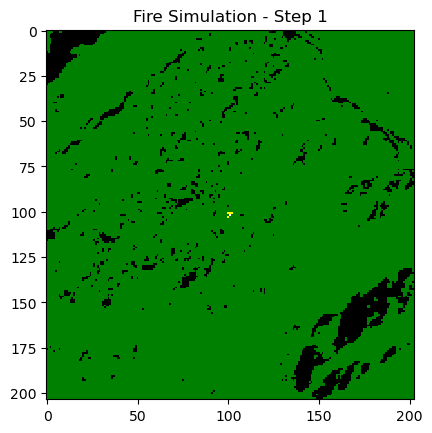

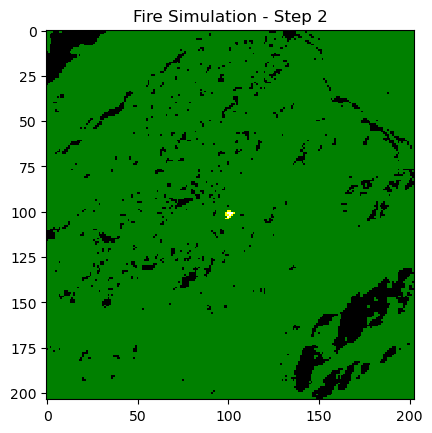

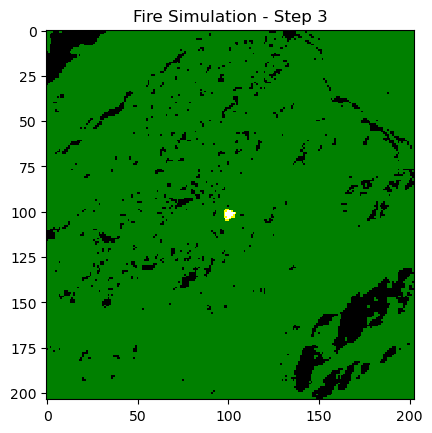

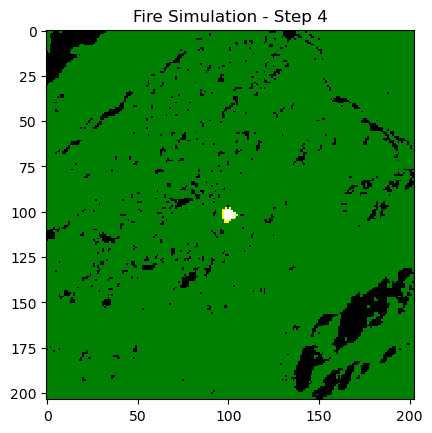

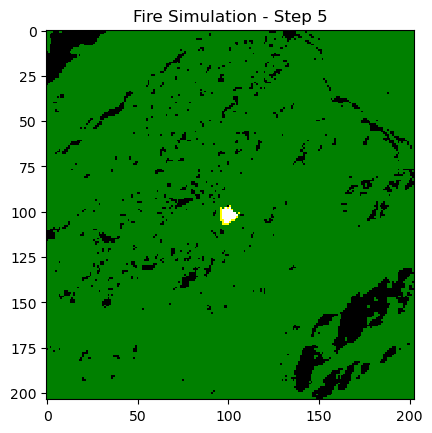

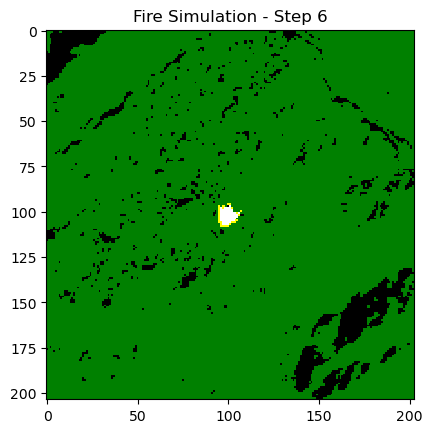

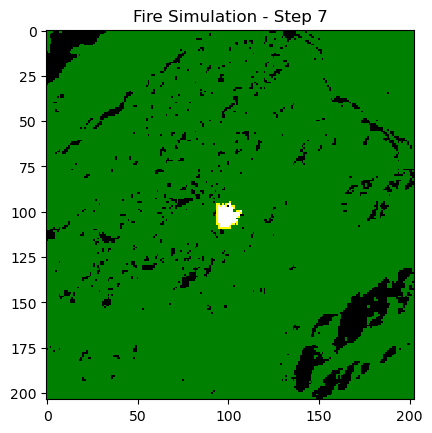

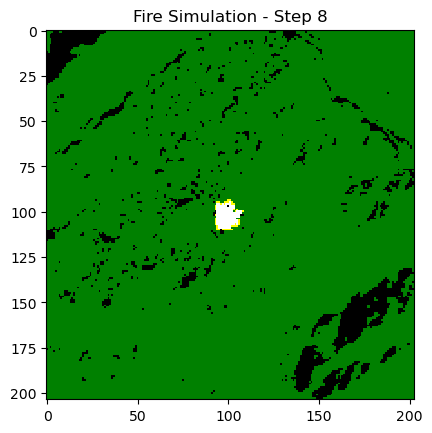

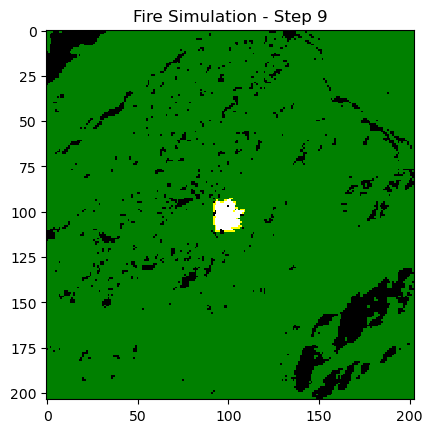

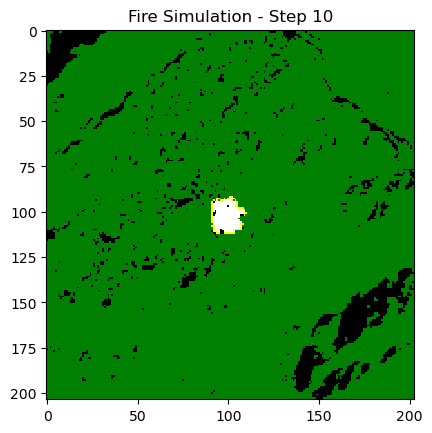

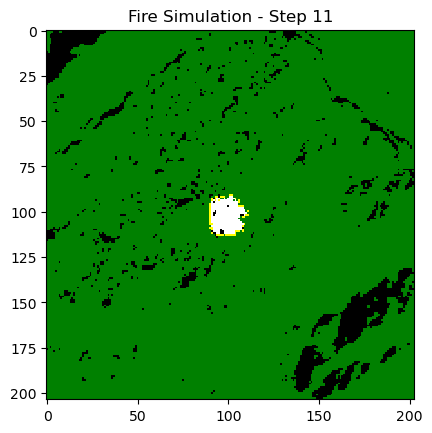

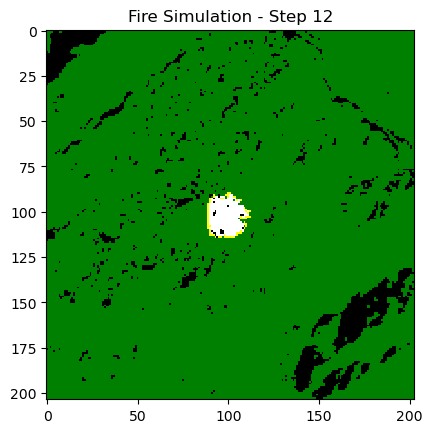

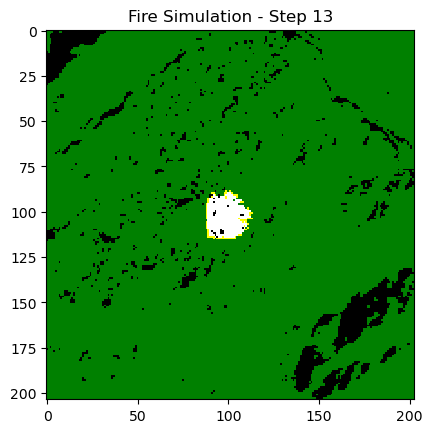

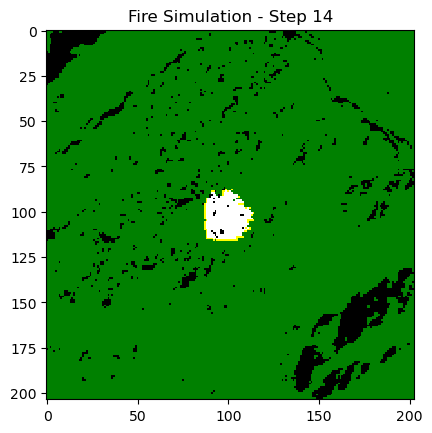

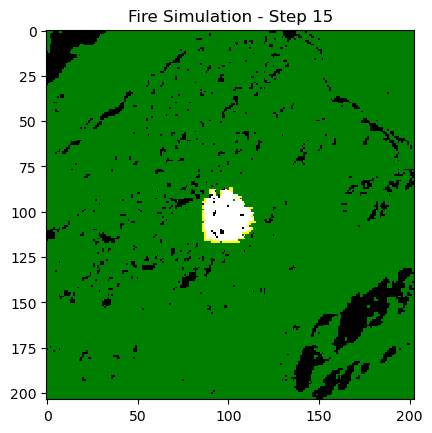

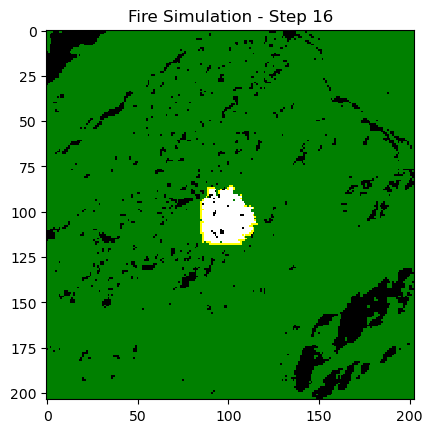

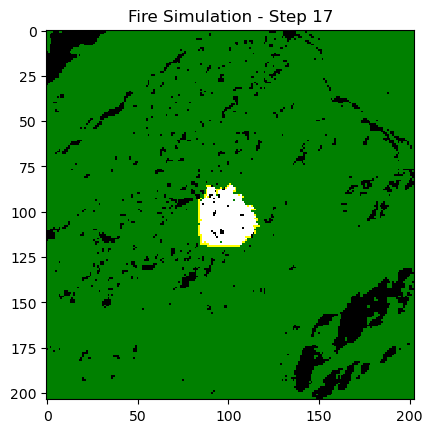

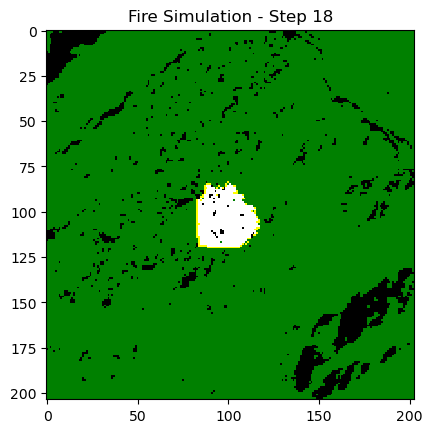

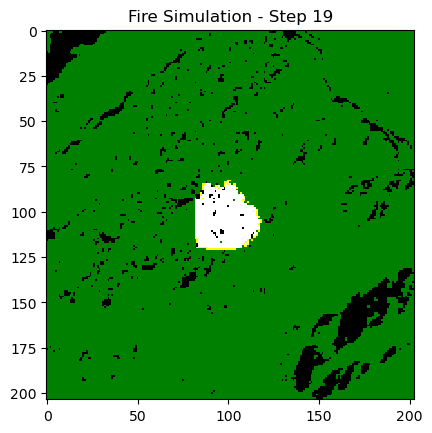

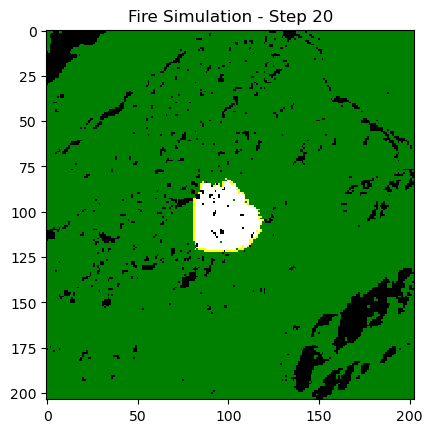

In [41]:
EMPTY = 0       # No vegetation
VEGETATION = 1  # Vegetation present (fuel)
BURNING = 2     # Actively burning
BURNED = 3      # Completely burned

# Define Moore Neighborhood (8 neighbors)
NEIGHBORHOOD = [(-1, -1), (-1, 0), (-1, 1),
                (0, -1),          (0, 1),
                (1, -1),  (1, 0), (1, 1)]

# Fire Spread Constants & Environmental Parameters
P0 = 0.58   # Base probability of fire spread
C1 = 0.045  # Wind speed coefficient
C2 = 0.131  # Wind direction coefficient
A = 0.078   # Elevation coefficient

WIND_SPEED = 5.7        # m/s
WIND_DIRECTION = 310    # degrees (example)
slope = 5               # degrees (assumed constant)


# Fire Simulation Functions
def ignite_fire(grid, ignition_point):
    x, y = ignition_point
    grid[x, y] = BURNING
    return grid

def calculate_fire_probability(p0, p_veg_factor, wind_speed, wind_dir, terrain_slope, fire_dir):
    theta = np.cos(np.deg2rad(abs(wind_dir - fire_dir)))
    P_w = np.exp(C1 * wind_speed) * np.exp(C2 * wind_speed * (theta - 1))
    P_ele = np.exp(A * terrain_slope)
    return p0 * (1 + p_veg_factor) * P_w * P_ele

def simulate_fire(forest_grid, fuel_map, steps=20):
    rows, cols = forest_grid.shape
    # Create a colormap for visualizing simulation state:
    # Black: EMPTY, Green: VEGETATION, Yellow: BURNING, White: BURNED
    sim_cmap = ListedColormap(['black', 'green', 'yellow', 'white'])
    
    for step in range(steps):
        new_grid = forest_grid.copy()
        for x in range(1, rows - 1):
            for y in range(1, cols - 1):
                if forest_grid[x, y] == BURNING:
                    # Burn out the current cell
                    new_grid[x, y] = BURNED
                    # Check all 8 neighbors
                    for dx, dy in NEIGHBORHOOD:
                        nx, ny = x + dx, y + dy
                        if forest_grid[nx, ny] == VEGETATION:
                            fuel_type = fuel_map[nx, ny]
                            # Skip if there's no fuel (no vegetation)
                            if fuel_type == 0:
                                continue
                            p_veg_factor = fuel_to_factor.get(fuel_type, 0)
                            fire_dir = np.degrees(np.arctan2(dy, dx))
                            p_burn = calculate_fire_probability(P0, p_veg_factor, WIND_SPEED, WIND_DIRECTION, slope, fire_dir)
                            if np.random.rand() < p_burn:
                                new_grid[nx, ny] = BURNING
        forest_grid = new_grid.copy()
        plt.imshow(forest_grid, cmap=sim_cmap, interpolation='nearest')
        plt.title(f"Fire Simulation - Step {step+1}")
        plt.pause(0.1)
    plt.show()


# Main Execution Using NDVI GeoTIFF
ndvi_file_path = "data/CA_VEG_Sentinel2_NDVI.tif"

ndvi_norm = load_and_normalize_ndvi(ndvi_file_path) # Load and normalize NDVI data from the GeoTIFF
fuel_map = classify_vegetation(ndvi_norm) # Classify NDVI vlaues to create fuel map

forest_grid = np.where(fuel_map == 0, EMPTY, VEGETATION)

grid_size = forest_grid.shape

ignition_point = (grid_size[0] // 2, grid_size[1] // 2)
forest_grid = ignite_fire(forest_grid, ignition_point)

simulate_fire(forest_grid, fuel_map, steps=20)
